# Notebook 5: Modelling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import random

from difflib import SequenceMatcher

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

DATA_PATH = os.path.join('..', '..', 'data', '2_2', 'processed', 'modelling')
PAIRS_PATH = os.path.join('..', '..', 'data', '2_2', 'processed', 'pairs')

PARSED_DIR = os.path.join('..', '..', 'data', '2_2', 'processed', 'parsed')
OUTPUT_MANUAL_DIR = os.path.join(PARSED_DIR, 'manual')
OUTPUT_AUTO_DIR = os.path.join(PARSED_DIR, 'auto')

## 1. Load Data

In [2]:
def load_data(name):
    return pd.read_csv(os.path.join(DATA_PATH, f'{name}.csv'))

print("Loading Datasets...")
X_train = load_data('X_train')
y_train = load_data('y_train').values.ravel() 

X_val = load_data('X_val')
y_val = load_data('y_val').values.ravel()

X_test = load_data('X_test')
y_test = load_data('y_test').values.ravel()

print(f"Training Shape:   {X_train.shape}")
print(f"Validation Shape: {X_val.shape}")

Loading Datasets...
Training Shape:   (11458, 5)
Validation Shape: (139, 5)


## 2. Training Models
### 2.1 Logistic Regression

In [3]:
print("--- Training Baseline: Logistic Regression ---")

lr_model = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', random_state=42))

lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_val)
y_prob_lr = lr_model.predict_proba(X_val)[:, 1] 

print("Logistic Regression Results (Validation):")
print(classification_report(y_val, y_pred_lr))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob_lr):.4f}")

--- Training Baseline: Logistic Regression ---
Logistic Regression Results (Validation):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       115
           1       0.96      1.00      0.98        24

    accuracy                           0.99       139
   macro avg       0.98      1.00      0.99       139
weighted avg       0.99      0.99      0.99       139

ROC-AUC Score: 1.0000


### 2.2 Random Forest

In [4]:
print("--- Training & Tuning: Random Forest ---")

param_grid = {
    'n_estimators': [100, 200],      # number of trees
    'max_depth': [5, 10, None],      # maximum depth 
    'min_samples_split': [2, 5]      # minimum samples to split a node
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=3, scoring='f1', 
                           n_jobs=-1, verbose=1
                           )

grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print(f"\nBest Parameters Found: {grid_search.best_params_}")

y_pred_rf = best_rf.predict(X_val)
y_prob_rf = best_rf.predict_proba(X_val)[:, 1]

print("\nRandom Forest Results (Validation):")
print(classification_report(y_val, y_pred_rf))
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_prob_rf):.4f}")

--- Training & Tuning: Random Forest ---
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best Parameters Found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest Results (Validation):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       115
           1       0.92      1.00      0.96        24

    accuracy                           0.99       139
   macro avg       0.96      0.99      0.98       139
weighted avg       0.99      0.99      0.99       139

ROC-AUC Score: 0.9951


### 2.3 Model Comparison


Logistic Regression AUC: 1.0000
Random Forest AUC:       0.9951

>> Selected Best Model: Logistic Regression


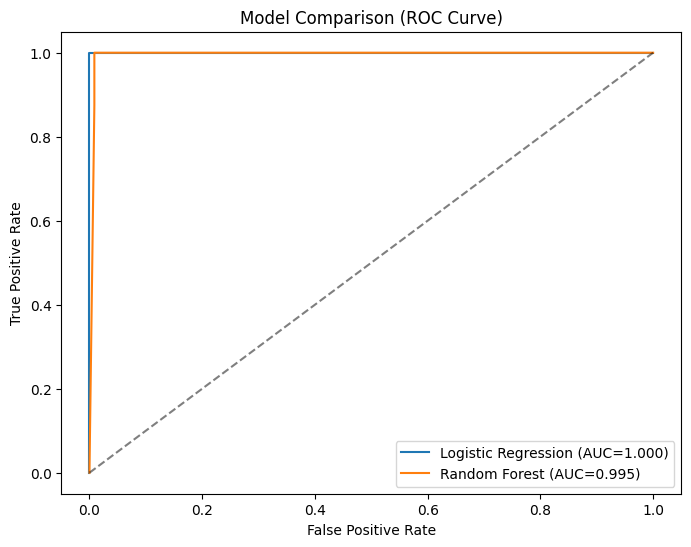

Confusion Matrix (Logistic Regression):


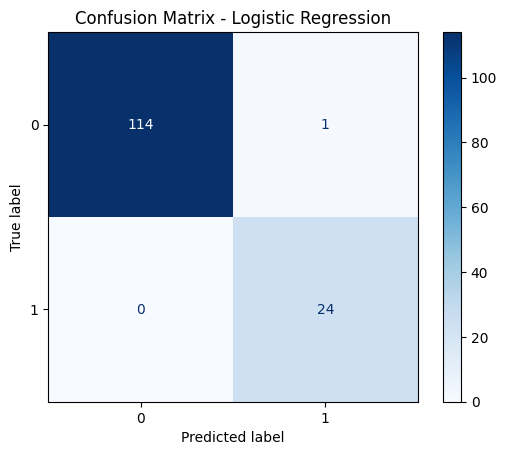

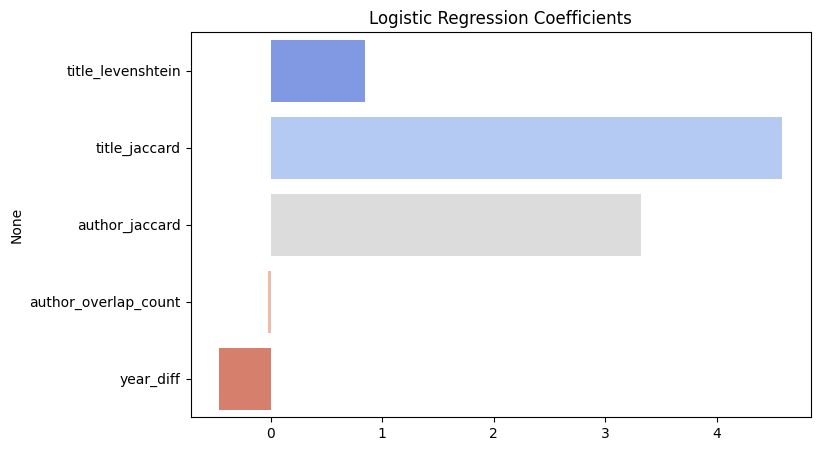

In [5]:
auc_lr = roc_auc_score(y_val, y_prob_lr)
auc_rf = roc_auc_score(y_val, y_prob_rf)

print(f"\nLogistic Regression AUC: {auc_lr:.4f}")
print(f"Random Forest AUC:       {auc_rf:.4f}")

if auc_rf >= auc_lr:
    best_model = best_rf
    best_model_name = "Random Forest"
    best_y_pred = y_pred_rf
    best_y_prob = y_prob_rf
else:
    best_model = lr_model
    best_model_name = "Logistic Regression"
    best_y_pred = y_pred_lr
    best_y_prob = y_prob_lr

print(f"\n>> Selected Best Model: {best_model_name}")

fpr_lr, tpr_lr, _ = roc_curve(y_val, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison (ROC Curve)')
plt.legend()
plt.show()

print(f"Confusion Matrix ({best_model_name}):")
ConfusionMatrixDisplay.from_predictions(y_val, best_y_pred, cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

if best_model_name == "Random Forest":
    importances = best_model.feature_importances_
    feature_names = X_train.columns
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances, y=feature_names, palette='viridis', hue = feature_names, legend=False)
    plt.title("Random Forest Feature Importance")
    plt.show()
elif best_model_name == "Logistic Regression":
    coeffs = best_model.named_steps['logisticregression'].coef_[0]
    feature_names = X_train.columns
    plt.figure(figsize=(8, 5))
    sns.barplot(x=coeffs, y=feature_names, palette='coolwarm', hue = feature_names, legend=False)
    plt.title("Logistic Regression Coefficients")
    plt.show()

## 3. Final Test and Evaluation
### 3.1 Final Test

--- Final Evaluation on Test Set (Logistic Regression) ---
Test Set Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       410
           1       0.95      1.00      0.98        82

    accuracy                           0.99       492
   macro avg       0.98      1.00      0.99       492
weighted avg       0.99      0.99      0.99       492

Test ROC-AUC: 0.9999
Confusion Matrix (Logistic Regression on Test Set):


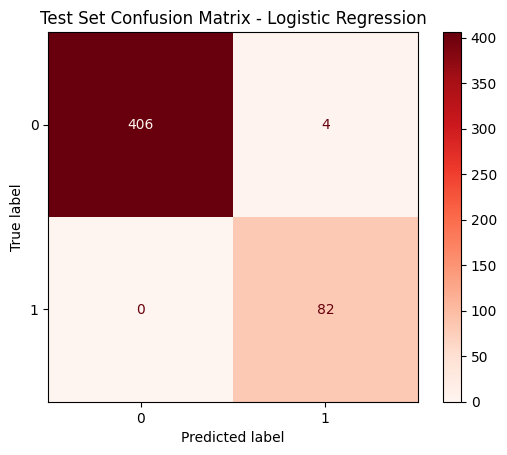

In [6]:
print(f"--- Final Evaluation on Test Set ({best_model_name}) ---")

y_pred_test = best_model.predict(X_test)
y_prob_test = best_model.predict_proba(X_test)[:, 1]

print("Test Set Classification Report:")
print(classification_report(y_test, y_pred_test))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob_test):.4f}")

print(f"Confusion Matrix ({best_model_name} on Test Set):")
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Reds')
plt.title(f"Test Set Confusion Matrix - {best_model_name}")
plt.show()

### 3.2 Evaluation

In [7]:
with open(os.path.join(PAIRS_PATH, 'manual_pairs.json'), 'r', encoding='utf-8') as f:
    manual_data = json.load(f)

def calculate_features_for_mrr(pairs):
    feats = []
    for p in pairs:
        src = p['source']
        cand = p['candidate']
        
        # title features
        t1, t2 = src.get('clean_title', ''), cand.get('clean_title', '')
        lev = SequenceMatcher(None, t1, t2).ratio()
        
        t1_tok, t2_tok = set(t1.split()), set(t2.split())
        jac = len(t1_tok & t2_tok) / len(t1_tok | t2_tok) if (t1_tok | t2_tok) else 0.0
        
        # author features 
        a1 = set(src.get('clean_author_tokens', []))
        a2 = set(cand.get('clean_author_tokens', []))
        auth_jac = len(a1 & a2) / len(a1 | a2) if (a1 | a2) else 0.0
        auth_ov = len(a1 & a2)
        
        try:
            y1_str, y2_str = str(src.get('year', 0)), str(cand.get('year', 0))
            y1 = int(y1_str) if y1_str.isdigit() else 0
            y2 = int(y2_str) if y2_str.isdigit() else 0
            
            ydiff = min(abs(y1 - y2), 50)
        except:
            ydiff = 10
            
        feats.append([lev, jac, auth_jac, auth_ov, ydiff])
    
    return pd.DataFrame(feats, columns=X_train.columns)

In [8]:
with open(os.path.join(PAIRS_PATH, 'manual_pairs.json'), 'r', encoding='utf-8') as f:
    manual_grouped = json.load(f)
with open(os.path.join(PAIRS_PATH, 'auto_pairs.json'), 'r', encoding='utf-8') as f:
    auto_grouped = json.load(f)

def calculate_features_for_mrr(pairs):
    feats = []
    for p in pairs:
        src = p['source']
        cand = p['candidate']
        
        t1, t2 = src.get('clean_title', ''), cand.get('clean_title', '')
        lev = SequenceMatcher(None, t1, t2).ratio()
        
        t1_tok, t2_tok = set(t1.split()), set(t2.split())
        jac = len(t1_tok & t2_tok) / len(t1_tok | t2_tok) if (t1_tok | t2_tok) else 0.0
        
        a1 = set(src.get('clean_author_tokens', []))
        a2 = set(cand.get('clean_author_tokens', []))
        auth_jac = len(a1 & a2) / len(a1 | a2) if (a1 | a2) else 0.0
        auth_ov = len(a1 & a2)
        
        try:
            y1_str, y2_str = str(src.get('year', 0)), str(cand.get('year', 0))
            y1 = int(y1_str) if y1_str.isdigit() else 0
            y2 = int(y2_str) if y2_str.isdigit() else 0
            
            ydiff = min(abs(y1 - y2), 50)
        except:
            ydiff = 10
            
        feats.append([lev, jac, auth_jac, auth_ov, ydiff])
    
    feature_cols = ['title_levenshtein', 'title_jaccard', 'author_jaccard', 'author_overlap_count', 'year_diff']
    return pd.DataFrame(feats, columns=feature_cols)

def get_test_id_from_split(all_ids):
    all_ids.sort()
    random.seed(42) 
    random.shuffle(all_ids)
    return all_ids[0] if all_ids else None

man_ids = list(manual_grouped.keys())
auto_ids = list(auto_grouped.keys())

target_manual_id = get_test_id_from_split(man_ids)
target_auto_id = get_test_id_from_split(auto_ids)

print(f"Target Test Papers:")
print(f"  1. Manual: {target_manual_id}")
print(f"  2. Auto:   {target_auto_id}")

test_set_data = {}

if target_manual_id and target_manual_id in manual_grouped:
    test_set_data[target_manual_id] = manual_grouped[target_manual_id]

if target_auto_id and target_auto_id in auto_grouped:
    test_set_data[target_auto_id] = auto_grouped[target_auto_id]

print(f"\nEvaluating MRR on Test Set ({len(test_set_data)} papers)...")
print("="*60)

global_reciprocal_ranks = []

for paper_id, pairs in test_set_data.items():
    ptype = "MANUAL" if paper_id == target_manual_id else "AUTO"
    print(f"\nProcessing {ptype}: {paper_id}")
    
    grouped_by_source = {}
    for p in pairs:
        src_id = p['source']['id']
        if src_id not in grouped_by_source:
            grouped_by_source[src_id] = []
        grouped_by_source[src_id].append(p)
    
    paper_rrs = []
    
    for idx, (src_id, candidates) in enumerate(grouped_by_source.items()):
        features_df = calculate_features_for_mrr(candidates)
        probs = best_model.predict_proba(features_df)[:, 1]
        
        ranked_candidates = []
        for i, pair in enumerate(candidates):
            ranked_candidates.append({
                'prob': probs[i],
                'label': pair['label'], 
                'cand_id': pair['candidate']['id'],
                'cand_title': pair['candidate']['clean_title'][:60] + "..."
            })
        
        ranked_candidates.sort(key=lambda x: x['prob'], reverse=True)
        
        rr = 0
        found_rank = None
        for rank, item in enumerate(ranked_candidates[:5], start=1):
            if item['label'] == 1:
                rr = 1 / rank
                found_rank = rank
                break
        
        paper_rrs.append(rr)
        global_reciprocal_ranks.append(rr)

        if idx < 2:
            print(f"  Source [{src_id}]: Rank {found_rank if found_rank else '>5'}")
            print(f"    1. {ranked_candidates[0]['cand_id']} ({ranked_candidates[0]['prob']:.4f}) {'✅' if ranked_candidates[0]['label']==1 else ''}")

    if paper_rrs:
        print(f"-> Paper MRR: {sum(paper_rrs)/len(paper_rrs):.4f}")

print("\n" + "="*60)
if global_reciprocal_ranks:
    final_mrr = sum(global_reciprocal_ranks) / len(global_reciprocal_ranks)
    print(f"FINAL TEST SET MRR: {final_mrr:.4f}")
    print(f"Total Queries Evaluated: {len(global_reciprocal_ranks)}")
else:
    print("Error: No test pairs found.")
print("="*40)

Target Test Papers:
  1. Manual: 2211.03616
  2. Auto:   2211.03044

Evaluating MRR on Test Set (2 papers)...

Processing MANUAL: 2211.03616
  Source [abcnn]: Rank 1
    1. 1512.05193 (1.0000) ✅
  Source [cnn1]: Rank 1
    1. 1503.03244 (1.0000) ✅
-> Paper MRR: 1.0000

Processing AUTO: 2211.03044
  Source [Min2022RethinkingTR]: Rank 1
    1. 2202.12837 (1.0000) ✅
  Source [Cui2022PrototypicalVF]: Rank 1
    1. 2203.09770 (1.0000) ✅
-> Paper MRR: 1.0000

FINAL TEST SET MRR: 1.0000
Total Queries Evaluated: 82


## 4. Create pred.json

In [ ]:
def split_dataset_ids(all_ids):
    all_ids.sort()
    random.seed(42) 
    random.shuffle(all_ids)
    
    if len(all_ids) < 3:
        return all_ids, [], []
        
    test_ids = [all_ids[0]]
    val_ids = [all_ids[1]]
    train_ids = all_ids[2:]
    
    return train_ids, val_ids, test_ids

with open(os.path.join(PAIRS_PATH, 'manual_pairs.json'), 'r', encoding='utf-8') as f:
    manual_grouped = json.load(f)
with open(os.path.join(PAIRS_PATH, 'auto_pairs.json'), 'r', encoding='utf-8') as f:
    auto_grouped = json.load(f)

id_to_partition = {}

m_train, m_val, m_test = split_dataset_ids(list(manual_grouped.keys()))
for pid in m_train: id_to_partition[pid] = "train"
for pid in m_val:   id_to_partition[pid] = "valid"
for pid in m_test:  id_to_partition[pid] = "test"

a_train, a_val, a_test = split_dataset_ids(list(auto_grouped.keys()))
for pid in a_train: id_to_partition[pid] = "train"
for pid in a_val:   id_to_partition[pid] = "valid"
for pid in a_test:  id_to_partition[pid] = "test"

def generate_and_save_predictions(data_grouped, output_root_dir, partition_map):
    count = 0
    for paper_id, pairs in data_grouped.items():
        partition_label = partition_map.get(paper_id, "train") 
        
        grouped_by_source = {}
        for p in pairs:
            src_id = p['source']['id']
            if src_id not in grouped_by_source:
                grouped_by_source[src_id] = []
            grouped_by_source[src_id].append(p)
        
        predictions = {}
        groundtruth_map = {}
        
        for src_id, candidates in grouped_by_source.items():
            features_df = calculate_features_for_mrr(candidates)
            probs = best_model.predict_proba(features_df)[:, 1]
            
            ranked_list = []
            correct_match = None
            
            for i, pair in enumerate(candidates):
                cand_id = pair['candidate']['id']
                score = probs[i]
                ranked_list.append((cand_id, score))
                
                if pair['label'] == 1:
                    correct_match = cand_id
            
            ranked_list.sort(key=lambda x: x[1], reverse=True)
            top_5 = [item[0] for item in ranked_list[:5]]
            
            predictions[src_id] = top_5
            if correct_match:
                groundtruth_map[src_id] = correct_match
                
        pred_output = {
            "partition": partition_label,
            "groundtruth": groundtruth_map,
            "prediction": predictions
        }
        
        paper_dir = os.path.join(output_root_dir, paper_id)
        os.makedirs(paper_dir, exist_ok=True)
        
        with open(os.path.join(paper_dir, 'pred.json'), 'w', encoding='utf-8') as f:
            json.dump(pred_output, f, indent=4)
        count += 1
            
    print(f"Generated {count} pred.json files in {output_root_dir}")



In [10]:
print("-" * 40)
generate_and_save_predictions(manual_grouped, OUTPUT_MANUAL_DIR, id_to_partition)
generate_and_save_predictions(auto_grouped, OUTPUT_AUTO_DIR, id_to_partition)
print("-" * 40)

----------------------------------------
Generated 5 pred.json files in ../../data/2_2/processed/parsed/manual
Generated 136 pred.json files in ../../data/2_2/processed/parsed/auto
----------------------------------------
